## Extraction performance as a function of divide-and-conquer size ##

In [1]:
%pylab inline
import numpy as np
from astropy.table import Table

/Users/sbailey/anaconda/envs/desi/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/sbailey/anaconda/envs/desi/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [35]:
knl = Table.read('../doc/data/extract-size/knl.txt', format='ascii')
hsw = Table.read('../doc/data/extract-size/hsw.txt', format='ascii')

In [36]:
hsw.colnames

['nspec', 'nwave', 'ntot', 'rate']

In [37]:
knl.sort('ntot')
hsw.sort('ntot')

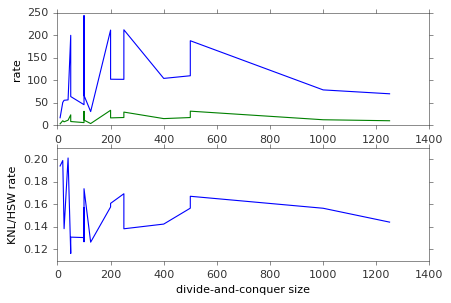

In [38]:
subplot(211)
plot(hsw['ntot'], hsw['rate'])
plot(knl['ntot'], knl['rate'])
ylabel('rate')
subplot(212)
plot(hsw['ntot'], knl['rate']/hsw['rate'])
xlabel('divide-and-conquer size')
ylabel('KNL/HSW rate')

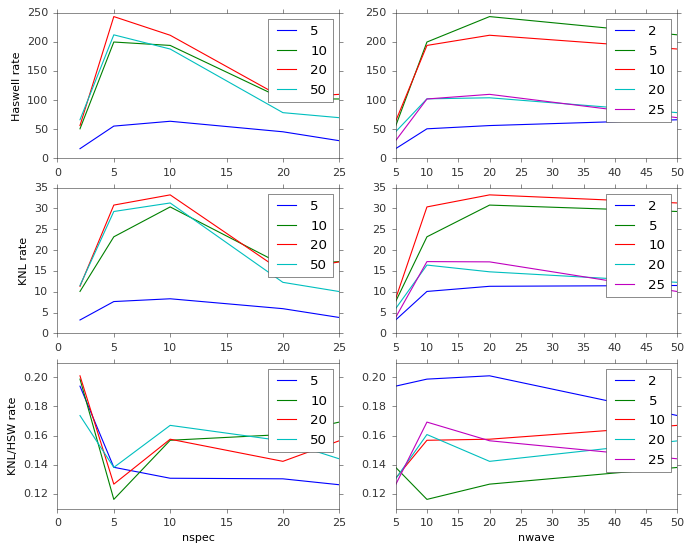

In [51]:
figure(figsize=(10,8))
subplot(321)
for n in sorted(set(hsw['nwave'])):
    ii = (hsw['nwave'] == n)
    plot(hsw['nspec'][ii], hsw['rate'][ii], label=str(n))
legend()
ylabel('Haswell rate')
# xlabel('nspec')

subplot(322)
for n in sorted(set(hsw['nspec'])):
    ii = (hsw['nspec'] == n)
    plot(hsw['nwave'][ii], hsw['rate'][ii], label=str(n))
legend()
# xlabel('nwave')

subplot(323)
for n in sorted(set(knl['nwave'])):
    ii = (knl['nwave'] == n)
    plot(knl['nspec'][ii], knl['rate'][ii], label=str(n))
legend()
ylabel('KNL rate')
# xlabel('nspec')

subplot(324)
for n in sorted(set(knl['nspec'])):
    ii = (knl['nspec'] == n)
    plot(knl['nwave'][ii], knl['rate'][ii], label=str(n))
legend()
# xlabel('nwave')

subplot(325)
for n in sorted(set(knl['nwave'])):
    ii = (knl['nwave'] == n)
    plot(knl['nspec'][ii], knl['rate'][ii] / hsw['rate'][ii], label=str(n))
legend()
ylabel('KNL/HSW rate')
xlabel('nspec')

subplot(326)
for n in sorted(set(knl['nspec'])):
    ii = (knl['nspec'] == n)
    plot(knl['nwave'][ii], knl['rate'][ii] / hsw['rate'][ii], label=str(n))
legend()
xlabel('nwave')


